In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#pytorch utility imports
import torch  #Thêm thư viện pytorch bằng dòng code: import torch
import torchvision #Để sử dụng chuyên biệt cho đọc và xử lý ảnh trên pytorch
import torchvision.transforms as transforms #transforms là các chức năng biến đổi hình ảnh đơn giản có thể được thực hiện theo trình tự ngay sau khi dataset (hình ảnh) được tả
import torchvision.datasets as datasets #load dataset .. từ torchvision.dataset
from torch.utils.data import DataLoader, TensorDataset
#TensorDataset(): đây là Dataset wrapping tensors. Các sample(ảnh) được lấy dựa vào indexing tensors dọc theo chiều đầu tiên của tensor.
#DataLoader(): Nó giúp kết hợp dataset and sampler. Và nó cũng cung cấp đa xử lý vòng lặp qua bộ dataset.
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn #sẽ sử dụng nó để xây dựng mạng nơ-ron thực tế của mình.
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math


In [3]:
# Prepare Dataset
# load data
train = pd.read_csv(r"/content/drive/MyDrive/Bài tập AI/mnist/train.csv",dtype = np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Logistic Regression

In [ ]:
#quy định:feature_numpy: láy feature từ tập train ; features_xtrain :numpy ;featuresxtrain(tensor)
#chia các ảnh với kích thước 28 * 28 (features_numpy) và 10 labels từ 0 đến 9.(targets_numpy)
targets_numpy = train.label.values#.value :trả về một đối tượng dạng danh sách tất cả các giá trị trong một từ điển nhất định.
features_numpy = train.loc[:,train.columns != "label"].values/255 # chuẩn hóa data ; 
#.loc[]: lấy nhãn chỉ mục và trả về hàng hoặc khung dữ liệu nếu nhãn chỉ mục tồn tại trong khung dữ liệu người gọi.

#Để chia dữ liệu train và test => hàm train_test_split trong sklearn.
#Ta sẽ chia kích thước của train data là 80% và của test data là 20%.
features_xtrain, features_xtest, y_train, y_test = train_test_split(features_numpy,
                                                                    targets_numpy,
                                                                    test_size = 0.2,
                                                                    random_state = 42) 
print(features_xtrain)
# tạo các  feature và  targets tensor cho train set.
featuresxtrain = torch.from_numpy(features_xtrain)
ytrain = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long
print(ytrain)

featuresxtest = torch.from_numpy(features_xtest)
ytest = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
tensor([6, 5, 3,  ..., 2, 6, 0])


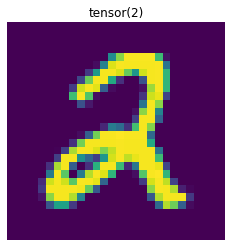

In [ ]:
# batch_size, epoch và iteration
batch_size = 100 #Batch size chính là kích thước của mỗi nhóm
n_iters = 10000
num_epochs = n_iters / (len(featuresxtrain) / batch_size)#33600/100 =336 => 10000/336 =29
num_epochs = int(num_epochs) #=29

# Pytorch train và test sets
train = torch.utils.data.TensorDataset(featuresxtrain,ytrain)
test = torch.utils.data.TensorDataset(featuresxtest,ytest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False) # không tráo
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
#tải một hoặc nhiều quá trình, tùy chỉnh thứ tự tải và tự động chia lô (đối chiếu) và ghim bộ nhớ tùy chọn

# Visualize 1 ảnh trong dataset.
plt.imshow(featuresxtrain[100].reshape(28,28))
plt.axis("off")
plt.title(ytrain[100])
plt.show()

In [ ]:
# Tạo Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Giống với linear regression.
        #self đại diện cho thể hiện của lớp. Bằng cách sử dụng từ khóa “self”, chúng ta có thể truy cập các thuộc tính và phương thức của lớp trong python
        self.linear = nn.Linear(input_dim, output_dim)
        # Trong pytorch, logistic function nằm trong loss function.
        # Vì vậy, thực sự chúng tôi không quên đặt nó, nó chỉ ở phần tiếp theo    
    def forward(self, x):
        out = self.linear(x)
        return out

# Khởi tạo Model Class
input_dim = 28*28 ## size của images
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# tạo logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)
print(model)
# Khởi tạo Loss Class .Ta sử dụng Cross entropy loss. Nó cũng chứa softmax(logistic function).
error = nn.CrossEntropyLoss()
print(error)

# Optimizer Class : SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(optimizer)


LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [ ]:
# Traning the Model
count = 0
loss_list = []; iteration_list = []
for epoch in range(num_epochs):
    # lặp lại trên toàn bộ tập dữ liệu đã cung cấp cho bạn batch_size các mẫu tại một thời điểm.
    for batch_idx, (images, labels) in enumerate(train_loader):# liệt kê; trainloader : nhiều batch
        train = Variable(images.view(-1, 28*28))# Xác định biến
        labels = Variable(labels)
        optimizer.zero_grad()#Xóa gradient
        outputs = model(train) # Chuyển tiếp nhân giống
        loss = error(outputs, labels) # Tính toán softmax và tổn thất entropy chéo
        loss.backward()# tính gradients
        optimizer.step()#cập nhật tham số
        count += 1
        # dự đoán
        if count % 50 == 0:
            correct = 0# tính Accuracy 
            total = 0
            # dự đoán test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                outputs = model(test)
                # nhận dự đoán từ giá trị lớn nhất
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)# tổng số nhãn
                correct += (predicted == labels).sum()# tổng số dự đoán đúng
            accuracy = 100 * correct / float(total)
            # lưu trữ loss và lặp lại
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))# Print Loss


Iteration: 500  Loss: 1.8386812210083008  Accuracy: 67.61904907226562%
Iteration: 1000  Loss: 1.608919620513916  Accuracy: 75.38095092773438%
Iteration: 1500  Loss: 1.281924843788147  Accuracy: 78.54762268066406%
Iteration: 2000  Loss: 1.2030448913574219  Accuracy: 79.96428680419922%
Iteration: 2500  Loss: 1.046263337135315  Accuracy: 80.94047546386719%
Iteration: 3000  Loss: 0.9319333434104919  Accuracy: 81.76190185546875%
Iteration: 3500  Loss: 0.8973380923271179  Accuracy: 82.27381134033203%
Iteration: 4000  Loss: 0.7577816247940063  Accuracy: 82.88095092773438%
Iteration: 4500  Loss: 0.9765750169754028  Accuracy: 83.35713958740234%
Iteration: 5000  Loss: 0.7959301471710205  Accuracy: 83.66666412353516%
Iteration: 5500  Loss: 0.7574345469474792  Accuracy: 84.02381134033203%
Iteration: 6000  Loss: 0.8678926825523376  Accuracy: 84.32142639160156%
Iteration: 6500  Loss: 0.6666726469993591  Accuracy: 84.57142639160156%
Iteration: 7000  Loss: 0.7190734148025513  Accuracy: 84.857139587402

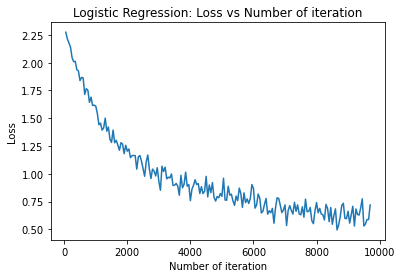

In [ ]:
# visualization
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()

**DL :Convolutional Neural Network (ANN)**

In [ ]:
# 1.Import Libraries
#2Xử lý Dataset
#Hoàn toàn giống như phần trước(logistic regression).
#Chúng ta sử dụng bộ data như cũ nên ta chỉ cần train_loader và test_loader.
#Ta sử dụng batch size, epoch và số vòng lặp như cũ.

In [ ]:
# 3.Tạo ANN Model
class ANNModel(nn.Module):
    #Thêm 3 hidden layers.
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        #Sử dụng ReLU, Tanh và ELU activation functions để giúp tăng sự đa dạng.
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu1 = nn.ReLU()        # Non-linearity 1
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.tanh2 = nn.Tanh()        # Non-linearity 2

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.elu3 = nn.ELU()         # Non-linearity 3

        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1,Non-linearity 1
        out = self.fc1(x)
        out = self.relu1(out)
        
        # Linear function 2,Non-linearity 2
        out = self.fc2(out)
        out = self.tanh2(out)
        
        # Linear function 2,Non-linearity 3
        out = self.fc3(out)
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

#4: Khởi tạo Model Class ANN
input_dim = 28*28 # size của ảnh
hidden_dim = 150 # hidden layer dim là một trong những tham số siêu và nó phải được chọn và điều chỉnh. Bây giờ tôi chỉ nói 150 không có lý do.
output_dim = 10 # labels 0,1,2,3,4,5,6,7,8,9
# Tạo model ANN
model = ANNModel(input_dim, hidden_dim, output_dim)#ANNModel => class
#5: sử dụng Cross entropy loss Và nó cũng chứa softmax(logistic function).
error = nn.CrossEntropyLoss()
# 6:Optimizer Class:SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#=>được model , error, optimizer 

In [ ]:
#7: ANN model training
count = 0
loss_list = []; iteration_list = []; accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1
        if count % 50 == 0:
            correct = 0;total = 0
            for images, labels in test_loader:
                test = Variable(images.view(-1, 28*28))
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.2224365770816803  Accuracy: 93.98809814453125 %
Iteration: 1000  Loss: 0.1303911805152893  Accuracy: 94.39286041259766 %
Iteration: 1500  Loss: 0.072276271879673  Accuracy: 94.54762268066406 %
Iteration: 2000  Loss: 0.11835435032844543  Accuracy: 94.91666412353516 %
Iteration: 2500  Loss: 0.1471141278743744  Accuracy: 95.1547622680664 %
Iteration: 3000  Loss: 0.05157946050167084  Accuracy: 95.48809814453125 %
Iteration: 3500  Loss: 0.14012521505355835  Accuracy: 95.64286041259766 %
Iteration: 4000  Loss: 0.02501772902905941  Accuracy: 95.80952453613281 %
Iteration: 4500  Loss: 0.16268417239189148  Accuracy: 95.82142639160156 %
Iteration: 5000  Loss: 0.04834284260869026  Accuracy: 96.03571319580078 %
Iteration: 5500  Loss: 0.1427762657403946  Accuracy: 95.9047622680664 %
Iteration: 6000  Loss: 0.10220875591039658  Accuracy: 96.08333587646484 %
Iteration: 6500  Loss: 0.0823286846280098  Accuracy: 96.38095092773438 %
Iteration: 7000  Loss: 0.04857737943530083  Accu

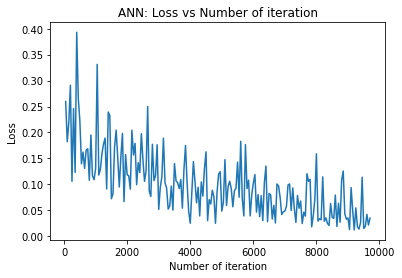

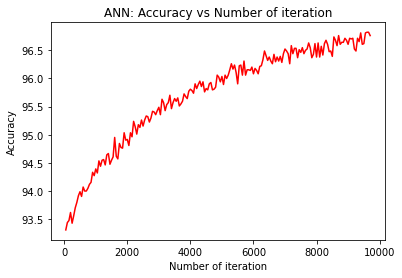

In [ ]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()